# Technical Stock Analysis: Predicting Stock Prices using LSTM

Author: Jacob McCabe

***Disclaimer: This is not meant to provide investment or trading advice.***

The stock market is the epitomy of a volatile, dynamic system; as such it is very challenging to make accurate predictions. There are numerous factors that go into an in-depth analysis such as politics, significant events, financial performance of a company, reputation, and way more.

Within stock analysis, there are two main bubbles: fundamental and technical analysis. Fundamental analysis can be overlysimplified to evaluating stocks by measurement of thier intrinsic value. It can be objective since it requires studying everything about a company from economic conditions to the company's management. Technical analysis is built on the assumption of all that information is factored into stock price. It aims to find opportunity via quantitative analysis.

We are going to be focusing on technical analysis, using a Simple Moving Average (MA) and Exponential MA as a benchmark for a deep learning model. The deep learning model that we will use is LSTM (Long Short-Term Memory). LSTMs are a type of recurrent neural network specifically designed for sequential data, including time series, speech, and text. This has made it commonly used in Natural Language Processing.


## Contents

1. Time Series Data
2. Evaluation Metrics
3. Helper Functions
4. Benchmark Models
    - Simple Moving Average
    - Exponential Moving Average
5. Introduction to LSTM
6. Training and Testing LSTM
7. Results

## Resources

- [Investopedia](https://www.investopedia.com/ask/answers/difference-between-fundamental-and-technical-analysis/#:~:text=Fundamental%20analysis%20evaluates%20securities%20by,future%20trends%20in%20stock%20prices.)
- [yfinance Documentation](https://pypi.org/project/yfinance/)
- [scikit-learn Documentation](https://scikit-learn.org/stable/)

## Library Imports

In [19]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras import Model, Input
from keras.layers import Dense, LSTM

## Getting the Time Series Data

Stock prices are often treated as a sequence or series of data points since the opening prices tomorrow are somewhat dependent on the closing prices of today. This allows us to analyze it as discrete-time data, or time-series observations that were taken on a daily basis.

For our data, we are going to use the open-source `yfinance` library which uses the publicly available Yahoo APIs to retrieve historical stock market data.

We are going to be using closing prices of General Electric's stock from the last 20 years: 9/22/2003 - 9/21/2023.

In [20]:
def retrieve_data(ticker, span):
    tickerInfo = yf.Ticker(ticker)
    return tickerInfo.history(period=span)

ticker = "GE"
span = "20Y" #could also use 'max'
stock_prices = retrieve_data(ticker, span)

In [21]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5035 entries, 2003-09-22 00:00:00-04:00 to 2023-09-21 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          5035 non-null   float64
 1   High          5035 non-null   float64
 2   Low           5035 non-null   float64
 3   Close         5035 non-null   float64
 4   Volume        5035 non-null   int64  
 5   Dividends     5035 non-null   float64
 6   Stock Splits  5035 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 314.7 KB


For the purposes of testing our LSTM model, we need to define how big we want our training data and test data to be. In this case, we are using the first 80% of our data for training the model and hopefully learn unseen dependencies. That leaves us with the last 20% of our data for testing the predictive accuracy of our model.

In [22]:
test_ratio = 0.2
train_ratio = 1 - test_ratio

train_size = int(train_ratio * len(stock_prices))
test_size = int(test_ratio * len(stock_prices))

print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train_size: 4028
test_size: 1007


## Evaluation Metrics

As with any learned model, we want well defined metrics to determine how well our model did to compare them against each other. For that purpose, we are going to use Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE). Both of these are useful measurements for forecasting accuracy.

$RMSE = \sqrt{\frac{1}{N}\sum_{t=1}^{N}(y_t - \hat{y}_t)^2}$,

$MAPE =  \frac{1}{N} \sum_{t=1}^{N} \lvert \frac{y_t - \hat{y}_t}{y_t} \rvert$,

where $N$ is the nunmber of data points, $y_t$ is the actual stock closing price at time $t$, and $\hat{y}_t$ is the predicted stock closing price at time $t$. Note that from here on, "stock closing price" and "stock price" will reference the same thing.

RMSE is useful because the units are the same as the data, and it gives a comparable error between datasets and models. MAPE measures the difference between true and predicted values relative to the true values. This means that a MAPE of 5% means the average difference between the predicted and actual value is within 5% of the actual value.

In [23]:
def rmse_(y_true, y_pred) -> float:
    """
    Calculate the Root Mean Squared Error 

    y_true and y_pred must be numpy arrays

    """
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def mape_(y_true, y_pred) -> float:
    """
    Calculate the Mean Absolute Percentage Error
    
    y_true and y_pred must be numpy arrays
    
    """
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calc_perf_metrics(var):
    rmse = rmse_(np.array(stock_prices[train_size:]["Close"]),
                np.array(stock_prices[train_size:][var])
    )
    
    mape = mape_(np.array(stock_prices[train_size:]["Close"]),
                np.array(stock_prices[train_size:][var])
    )
    
    return rmse, mape

## Helper Functions

We are going to need some helper functions to create our models and visualize them.

- Split the stock data into training and test sets.

In [24]:
def train_test_split(stock_data):
    """
    Split the stock data set into training and test. It also 
    trims the data down to only closing prices.
    """
    train = stock_prices[:train_size][["Close"]]
    test = stock_prices[train_size:][["Close"]]

    return train, test

- Create our input sequences of length $N$ and the corresponding output that should come next.
- Preprocess the test data so that it is scaled based on how the training data was scaled. This prevents data leakage.

In [25]:
def get_seqX_outcomeY(data, N, offset):
    """
    Split the time-series into sequence X and its outcome Y

    data:   dataset
    N:      window size, e.g., 50 for 50 days prior
    offset: position to start split
    """
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i-N:i])
        y.append(data[i])
    
    return np.array(X), np.array(y)

def preprocess_testdata(data, scaler, window_size, test):
    """
    Preprocess the test set the same way as the training set.

    data:           dataset
    scaler:         The preprocessing scaler such as keras.preprocessing.StandardScaler
    window_size:    How far back to go for our dependencies
    test:           test set
    """
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i,0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_test

- Plot the stock trend for Moving Average models
- Plot the stock trend for LSTM model

In [26]:
def plot_stock_trend_ma(var, cur_title, stock_prices):
    """
    Plot stock trend for moving average model

    var:            the window of how big the moving average is
    cur_title:      plot title
    stock_prices:   data 
    """
    ax = stock_prices[["Close", var, "200day"]].plot(figsize=(20,10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")
    plt.show()

def plot_stock_trend_lstm(train, test):
    """
    Plot stock trend for LSTM model

    train:  training data
    test:   testing data, containing actual and predicted prices
    """
    plt.figure(figsize=(20,10))
    plt.plot(np.asarray(train.index),
             np.asarray(train["Close"]),
             label="Train Closing Price"
    )
    plt.plot(np.asarray(test.index),
             np.asarray(test["Close"]),
             label="Test Closing Price"
    )
    plt.plot(np.asarray(test.index),
             np.asarray(test["Predictions_lstm"]),
             label="Predicted Closing Price"
    )
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")
    plt.show()

## Benchmark Models

The motivation behind having these two models as a "benchmark", is to provide context for comparison to the LSTM model. We're going to use a Simple MA and Exponential MA model because they have been around for a long time and are popular for smoothing out random, volatile movement. After makeing each model, we will score it using our metrics from earlier before moving onto the LSTM model.

#### Simple Moving Average (SMA)

A SMA model calculates the average stock price over a certain time period of length $p$. This way, it only considers the last $p$ points and ignores the others. So the SMA at time $t$ for a moving average of length $p$ is:

$SMA_t = \frac{X_{t-p}+X_{t-p+1}+ \cdots + X_t }{p}$,

where $X_t$ is price at time $t$. We are going to be using a 50 day moving average, but will add a 200 day moving average for comparison.

We can see that for the 50 day SMA model, the RMSE = $7.21 and MAPE = 8.72%. This seems like a pretty good place to start, but lets see how an Exponential Moving Average model performs.

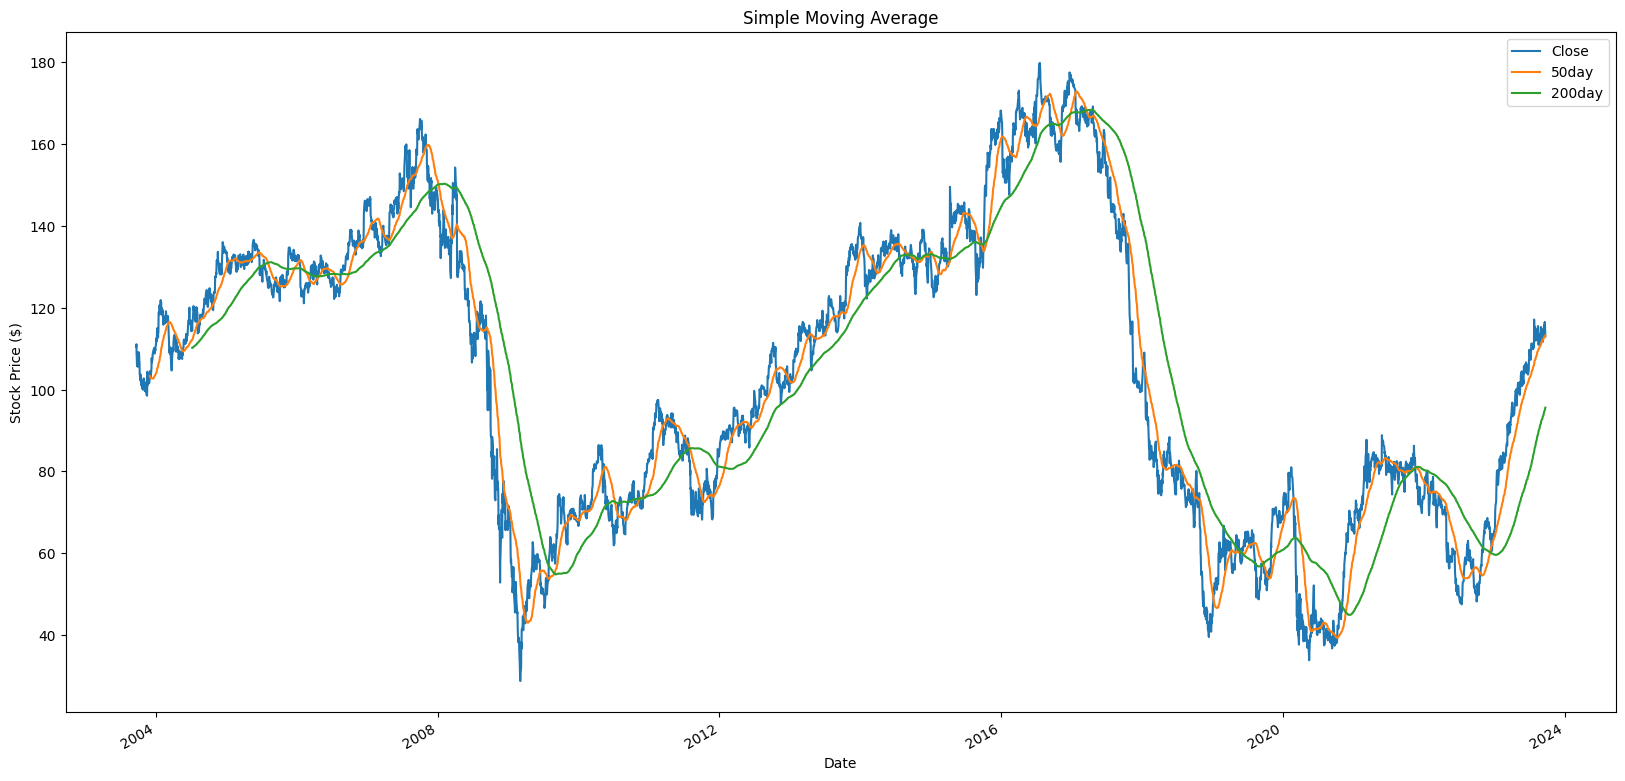

50-day SMA   RMSE: $7.21    MAPE: 8.72%


In [27]:
window_size = 50
window_var = f"{window_size}day"

stock_prices[window_var] = stock_prices["Close"].rolling(window_size).mean()
stock_prices["200day"] = stock_prices["Close"].rolling(200).mean()

plot_stock_trend_ma(var=window_var,
                 cur_title="Simple Moving Average",
                 stock_prices=stock_prices
)

rmse_sma, mape_sma = calc_perf_metrics(var=window_var)
print(f"{window_size}-day SMA   RMSE: ${rmse_sma:.2f}    MAPE: {mape_sma:.2f}%")

#### Exponential Moving Average (EMA)

With the SMA, each data point in the moving average was contributed equally. Intuitively, this seems like a big assumption. After all, the price from yesterday is probably a lot more important than the price from a month ago. This is what the EMA does - it applies a higher weight to the more recent points, while still considering the older ones. Thus it becomes more sensitive to price changes. For EMA at time $t$, we have:

$EMA_t = k*X_t + EMA_{t-1}(1-k)$,

where $k$ is a weighting factor and $X_t$ is the stock price at time $t$. We are going to use the same 50 day moving average and see how it performs.

As expected, the 50 day EMA performed better than the SMA: RMSE = $6.37 and MAPE = 7.79%. This was expected since we refined the assumptions we made about the way that stock market prices behave.

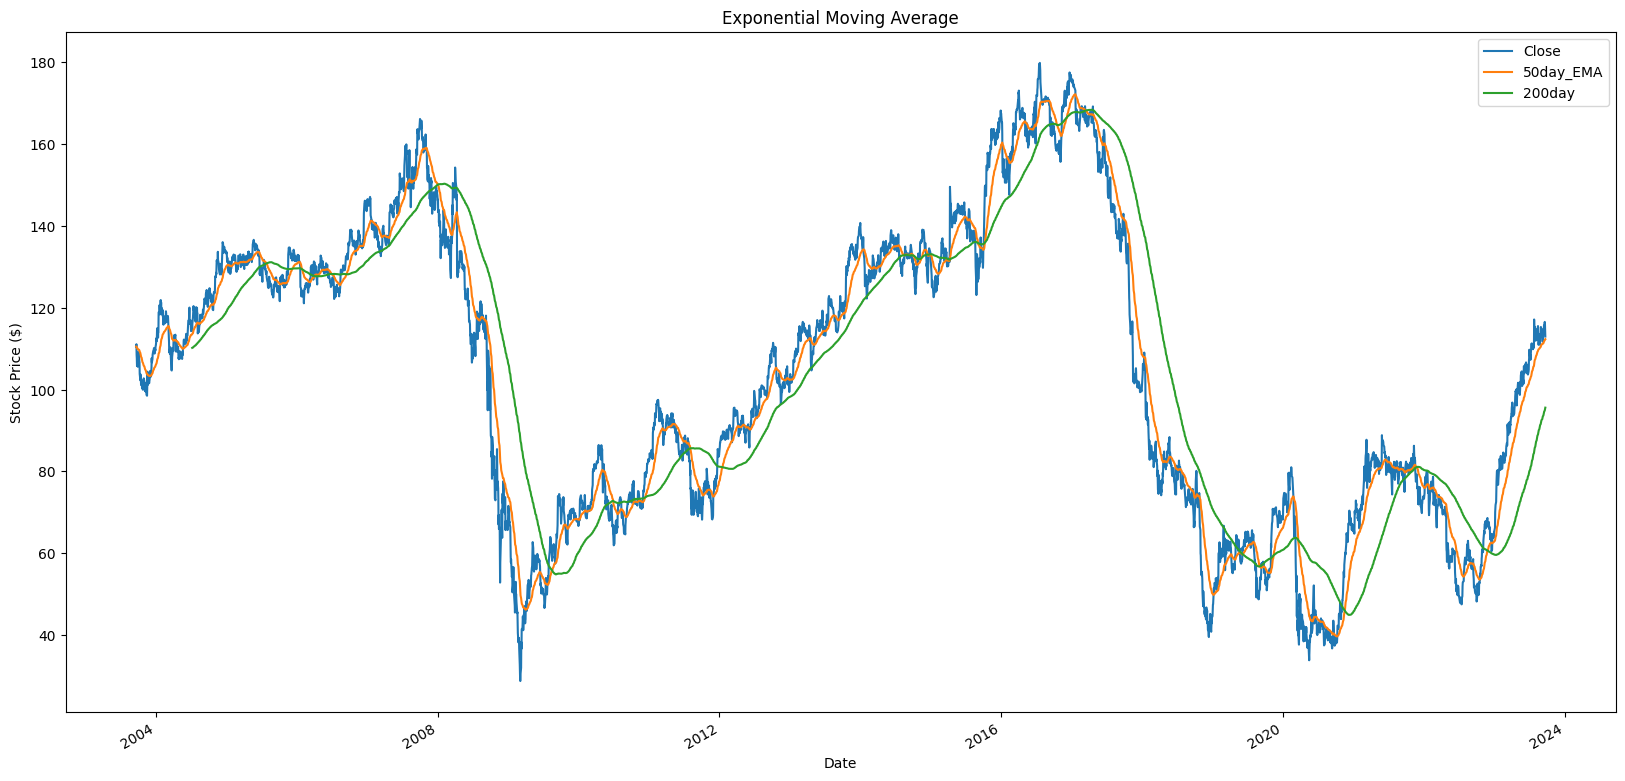

50-day EMA   RMSE: $6.37    MAPE: 7.79%


In [28]:
window_ema_var = f"{window_var}_EMA"

stock_prices[window_ema_var] = (
    stock_prices["Close"].ewm(span=window_size, adjust=False).mean()
)

plot_stock_trend_ma(var=window_ema_var,
                 cur_title="Exponential Moving Average",
                 stock_prices=stock_prices
)

rmse_ema, mape_ema = calc_perf_metrics(var=window_ema_var)
print(f"{window_size}-day EMA   RMSE: ${rmse_ema:.2f}    MAPE: {mape_ema:.2f}%")

## Introduction to LSTM

As mentioned earlier, LSTM (Long Short-Term Memory) is a deep learning model that is related to recurrent neural networks (RNNs). It processes sequential input data to make a prediction about what should come next. This is useful since sequential data such as stock prices often have hidden components such as trend, seasonality, and others that are hard to capture. In the end, it is able to learn long-term dependencies in the data, which is where previous models such as RNNs often struggle.

The structure of a LSTM model is similar to a RNN, but it has three sections called "gates". The first gate is usually called the "forget gate". It's purpose is to decide whether the information from the previous step is worth keeping. Next comes the "input gate" where new information is used to add and update the system. Lastly, the "output gate" which passes the updated information. All three of these gates together can be thought of as a single layer. 

## Training and Testing LSTM

As with most learning algorithms, there are a few hyperparameters that we need to specify. All of these are standard with deep learning: the number of hidden units, an optimizer, the loss function, how long to train, and the minibatch size. 

In [29]:
n_units = 50
optimizer = "adam"
loss = "mean_squared_error"
epochs = 15
batch_size = 20

In order to train a model, we first have to specify the layers. We're going to use two hidden layers with a linear output layer.

In [30]:
def run_lstm(X_train):

    input = Input(shape=(X_train.shape[1], 1))
    hidden1 = LSTM(units=n_units, return_sequences=True)(input)
    hidden2 = LSTM(units=n_units)(hidden1)
    output = Dense(1, activation="linear")(hidden2)

    model = Model(input, output)
    model.compile(loss=loss, optimizer=optimizer)

    return model

Finally, before we start training the model, there are a few more loose ends to tie up. First is to scale our data to be standard normal, i.e., remove the mean and scale the variance to 1. This is important because large values or a wide spread in values can be computationally unreliable and cause exploding/vanishing gradients. Second, we want to split our data into training and test sets as well as produce the features and targets. Luckily, we already took care of that earlier when we made our helper functions.

In [31]:
scaler = StandardScaler()
closing_prices = np.array(stock_prices["Close"]).reshape(-1,1)
scaled_data = scaler.fit_transform(closing_prices)

train, test = train_test_split(stock_data=stock_prices)

scaled_training_data = scaled_data[:train.shape[0]]

X_train, y_train = get_seqX_outcomeY(scaled_training_data,
                                     window_size,
                                     window_size)

Its finally time to run our model. Luckily for us, it only takes a few minutes to train since it's a small model.

In [32]:
model = run_lstm(X_train)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1,
                    validation_split=0.1,
                    shuffle=True
)

Epoch 1/15
179/179 [==============================] - 11s 37ms/step - loss: 0.0426 - val_loss: 0.0139
Epoch 2/15
179/179 [==============================] - 6s 31ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 3/15
179/179 [==============================] - 6s 33ms/step - loss: 0.0079 - val_loss: 0.0104
Epoch 4/15
179/179 [==============================] - 6s 32ms/step - loss: 0.0070 - val_loss: 0.0086
Epoch 5/15
179/179 [==============================] - 6s 31ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 6/15
179/179 [==============================] - 6s 32ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 7/15
179/179 [==============================] - 6s 32ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 8/15
179/179 [==============================] - 6s 33ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 9/15
179/179 [==============================] - 6s 31ms/step - loss: 0.0044 - val_loss: 0.0045
Epoch 10/15
179/179 [==============================] - 6s 33ms/step - loss: 0.0039 - val_l

With the the model trained, we want to process the test data the same way that we processed the training data. Doing this means that we aren't using any info from the test data to make the predictions. Its as if we don't know anything about it at all; everything the model learned is from the training data.

In [33]:
X_test = preprocess_testdata(data=stock_prices,
                             scaler=scaler,
                             window_size=window_size,
                             test=test
)

preds_ = model.predict(X_test)
preds = scaler.inverse_transform(preds_)

test["Predictions_lstm"] = preds

32/32 [==============================] - 1s 14ms/step


Now we can take a look at how well our LSTM model performed. Recall that with the EMA we made, the RMSE = $6.37 and MAPE = 7.79%. With a small deep learning model, we brought both of those down dramatically: RMSE = $1.74 and MAPE = 1.99%. For reference, by looking at the graph there is hardly a difference between the actual closing prices and predicted closing prices. 

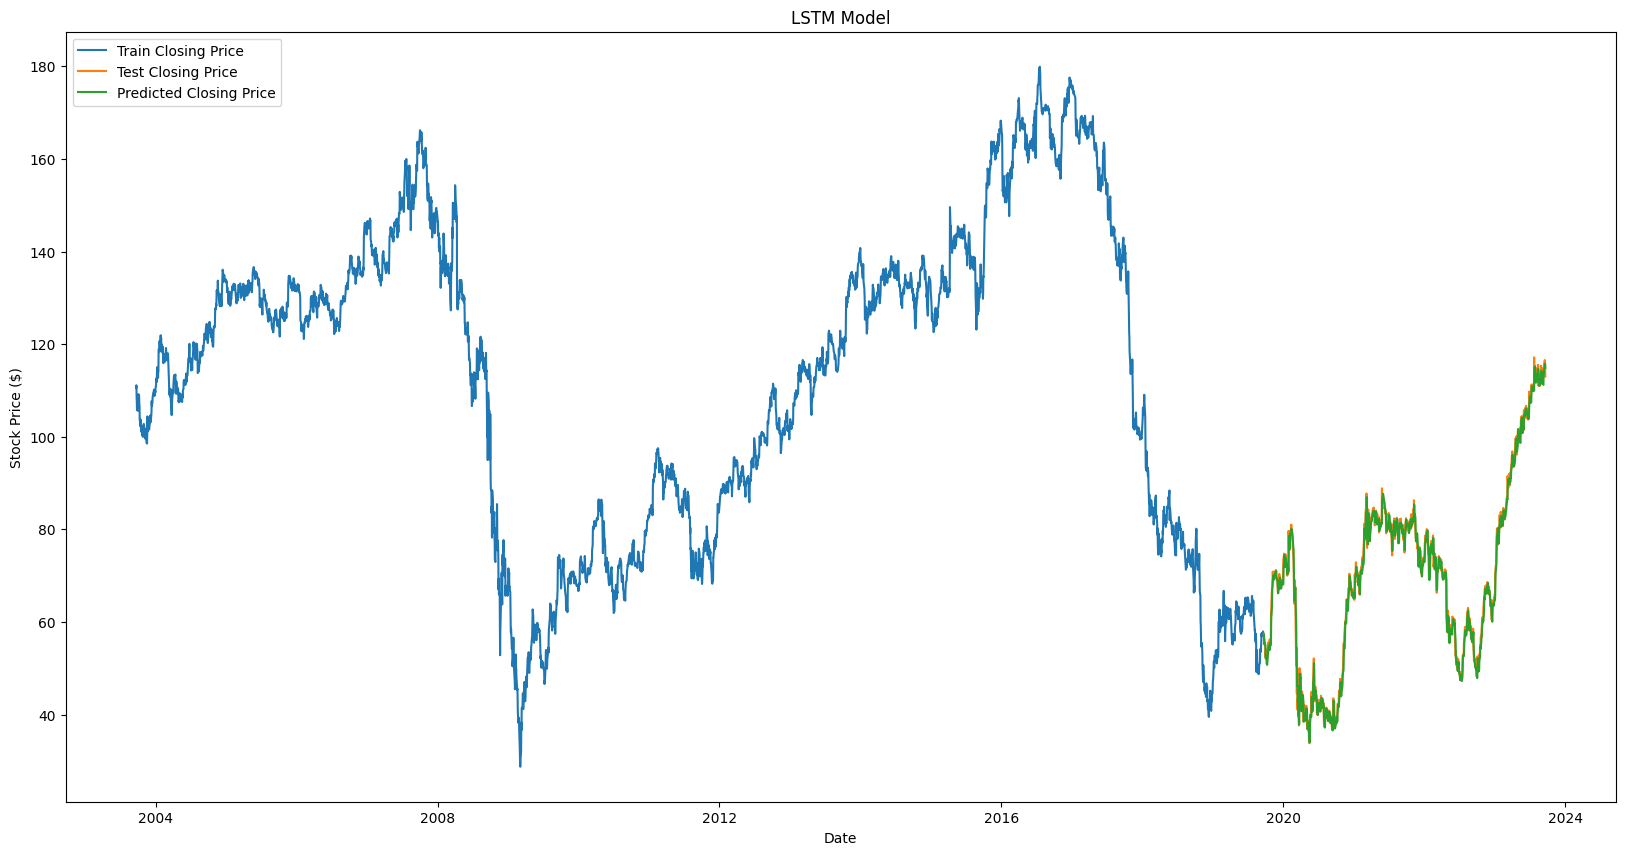

50-day LSTM   RMSE: $1.74    MAPE: 1.99%


In [34]:
plot_stock_trend_lstm(train=train, test=test)

rmse_lstm = rmse_(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = mape_(np.array(test["Close"]), np.array(test["Predictions_lstm"]))

print(f"{window_size}-day LSTM   RMSE: ${rmse_lstm:.2f}    MAPE: {mape_lstm:.2f}%")

## Results and Final Thoughts

As expected, the LSTM model provided a dramatic improvement over MA models. However, we should take this with a grain of salt since stock prices are volatile and chaotic systems and LSTMs work best to learn long-term dependencies. So the generalization of this model for other companies may not work well. It is likely that LSTMs will work best for mature companies that have a strong footing in the market and not those with high-volatility.

For expanding this model, it would be interesting to add in a sentiment analysis of media coverage and public company records. The nuance of language could give insight to how management and media feels about earnings and the company's intrinsic value.